In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch.optim as optim
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader


In [2]:
# Load data
df = pd.read_csv('master_csv_0.csv')

# Choose features
imu_features = [
    'accel_x_filtered', 'accel_z_filtered', 'gyro_y_filtered', 'gyro_z_filtered'
]
target_column = 'filtered_emg'

imu_segments = []
emg_segments = []

# Loop over unique segments
for segment_uid in df['Segment UID'].unique():
    segment_df = df[df['Segment UID'] == segment_uid]

    # Extract IMU and EMG data
    imu_data = segment_df[imu_features].values
    emg_data = segment_df[target_column].values

    # Store them as separate entries
    imu_segments.append(imu_data)
    emg_segments.append(emg_data)


In [3]:
class IMUtoEMG_CNN(nn.Module):
    def __init__(self, input_features):
        super(IMUtoEMG_CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_features, out_channels=64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 64, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm1d(64)
        self.conv_out = nn.Conv1d(64, 1, kernel_size=1)  # output EMG

    def forward(self, x):
        # x: (batch_size, seq_length, input_features)
        x = x.transpose(1, 2)  # to (batch_size, input_features, seq_length)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.conv_out(x)
        x = x.transpose(1, 2)  # back to (batch_size, seq_length, 1)
        return x


In [4]:
class IMU_EMG_Dataset(Dataset):
    def __init__(self, imu_segments, emg_segments):
        self.imu_segments = imu_segments
        self.emg_segments = emg_segments

    def __len__(self):
        return len(self.imu_segments)

    def __getitem__(self, idx):
        imu = torch.tensor(self.imu_segments[idx], dtype=torch.float32)   # shape: (seq_len, imu_features)
        emg = torch.tensor(self.emg_segments[idx], dtype=torch.float32)   # shape: (seq_len,)
        emg = emg.unsqueeze(-1)  # Make it (seq_len, 1) to match output shape
        return imu, emg


In [5]:
def collate_fn(batch):
    imu_batch, emg_batch = zip(*batch)  # unzip the list of tuples
    
    # imu_batch is a list of tensors with shape (seq_len, imu_features)
    # emg_batch is a list of tensors with shape (seq_len, 1)
    
    # Pad sequences to the max length in this batch
    imu_batch_padded = pad_sequence(imu_batch, batch_first=True)   # shape: (batch_size, max_seq_len, imu_features)
    emg_batch_padded = pad_sequence(emg_batch, batch_first=True)   # shape: (batch_size, max_seq_len, 1)
    
    return imu_batch_padded, emg_batch_padded


In [6]:
dataset = IMU_EMG_Dataset(imu_segments, emg_segments)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)


Epoch 1/20, Loss: 293.6984
Epoch 2/20, Loss: 291.7280
Epoch 3/20, Loss: 294.8923
Epoch 4/20, Loss: 297.3481
Epoch 5/20, Loss: 293.5473
Epoch 6/20, Loss: 293.4439
Epoch 7/20, Loss: 293.7439
Epoch 8/20, Loss: 291.8661
Epoch 9/20, Loss: 299.5491
Epoch 10/20, Loss: 290.5861
Epoch 11/20, Loss: 294.6627
Epoch 12/20, Loss: 291.3434
Epoch 13/20, Loss: 294.7739
Epoch 14/20, Loss: 289.8302
Epoch 15/20, Loss: 292.7190
Epoch 16/20, Loss: 292.4846
Epoch 17/20, Loss: 294.2985
Epoch 18/20, Loss: 294.7692
Epoch 19/20, Loss: 293.6589
Epoch 20/20, Loss: 291.7070


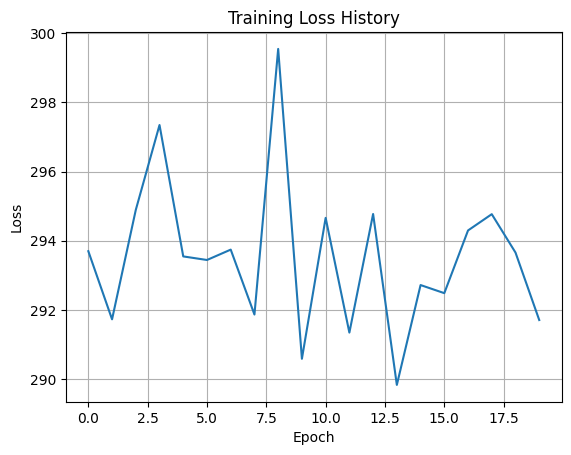

In [7]:
model = IMUtoEMG_CNN(input_features=imu_segments[0].shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
loss_history = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for imu_batch, emg_batch in dataloader:
        optimizer.zero_grad()
        pred = model(imu_batch)
        loss = criterion(pred, emg_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    loss_history.append(epoch_loss)

# Plot training loss
plt.plot(loss_history)
plt.title("Training Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()


In [8]:
# Assuming you have one segment's IMU data:
imu_segment_test = imu_segments[0]  # shape: (seq_len, imu_features)

# Convert to tensor
imu_tensor = torch.tensor(imu_segment_test, dtype=torch.float32)

# Add batch dimension
imu_tensor = imu_tensor.unsqueeze(0)  # shape: (1, seq_len, imu_features)

# Model in eval mode
model.eval()
with torch.no_grad():
    predicted_emg = model(imu_tensor)  # shape: (1, seq_len, 1)

# Remove batch dimension
predicted_emg = predicted_emg.squeeze(0).squeeze(-1).numpy()  # shape: (seq_len,)


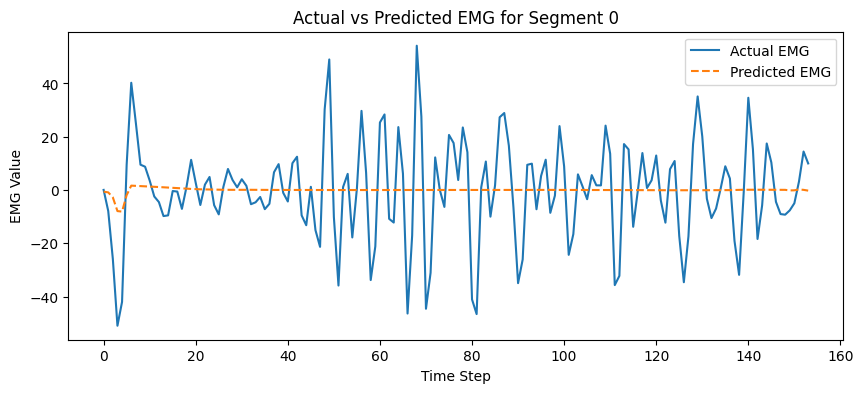

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(emg_segments[0], label='Actual EMG')
plt.plot(predicted_emg, label='Predicted EMG', linestyle='--')
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("EMG Value")
plt.title("Actual vs Predicted EMG for Segment 0")
plt.show()
